In [1]:
import pickle
import matplotlib.pyplot as plt

from classifier import *
from preprocessing import *
from staff_removal import *
from helper_methods import *

In [2]:
# Get paths of scaned and captured test cases #
scanned_path = './test-cases/test-set-scanned/scanned'
captured_path = './test-cases/test-set-camera-captured/captured'

img_filenames = os.listdir(scanned_path)
for i, fn in enumerate(img_filenames):
    test_number = fn.split('.')[0]

In [3]:
def preprocess_img(img_path, output_path):
    # 1. Read desired image #
    img = cv2.imread(img_path, 0)
    
    # 2. Remove noise (odd pixels) from the image and save it #
    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    cv2.imwrite('testing-output/{}/1. noise_removed.png'.format(output_path), img)

    # 3. Binarize image using combination of (global + otsu) thresholding and save it #
    threshold, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2.imwrite('testing-output/{}/2. binarized.png'.format(output_path), img)

    # 4. Return image shape (width, height) and processed image # 
    n, m = img.shape
    return n, m, img

## Steps of processing
1. ~Apply Pre-processing~
2. ~Remove Staff lines~
3. ~Cut images into buckets~
4. ~Get reference line for each bucket~
5. ~Segment symbols, Sort them by x-value~
6. Classify symbol

## Loading dataset

In [4]:
print('Loading dataset. This will take time ...')
features, labels = load_dataset('hog')
print('Finished loading dataset.')

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=random_seed)

Loading dataset. This will take time ...
finished processing:  a_1
finished processing:  a_16
finished processing:  a_16_flipped
finished processing:  a_2
finished processing:  a_2_flipped
finished processing:  a_32
finished processing:  a_4
finished processing:  a_4_flipped
finished processing:  a_8
finished processing:  a_8_flipped
finished processing:  b
finished processing:  barline
finished processing:  b_16
finished processing:  b_16_flipped
finished processing:  b_8
finished processing:  b_8_flipped
finished processing:  chord_2
finished processing:  chord_3
finished processing:  chord_3_2
finished processing:  chord_special
finished processing:  clef
finished processing:  d
finished processing:  dot
finished processing:  hash
finished processing:  symbol_bb
finished processing:  t_2
finished processing:  t_4
finished processing:  x
Finished loading dataset.


## Training and saving the model

In [5]:
model_name = 'SVM'
model = run_experiment(train_features, test_features, train_labels, test_labels, model_name)

filename = f'{model_name}.sav'
pickle.dump(model, open(filename, 'wb'))
 
# TODO: Use this line to load the model 
# model = pickle.load(open(filename, 'rb'))

############## Training SVM ##############
SVM accuracy: 99.2831541218638 %


## Testing 

a_8_flipped


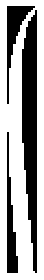

barline


C:\Users\abdal\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


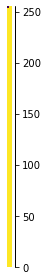

clef


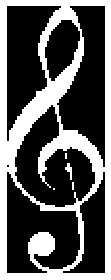

t_4


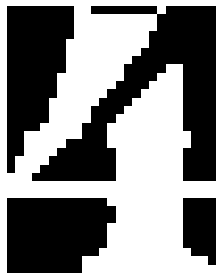

t_4


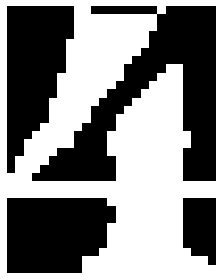

a_4


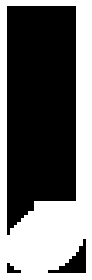

a_32


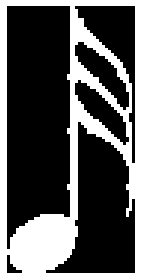

a_2_flipped


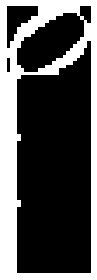

a_8


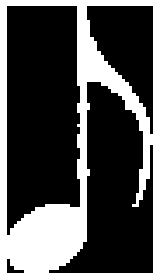

a_16


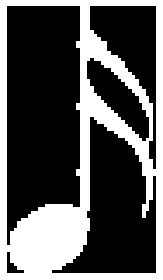

a_32


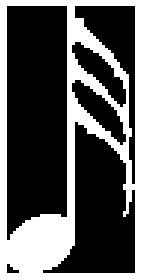

barline


chord_2


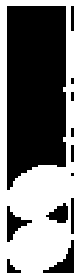

a_4


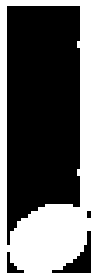

a_8


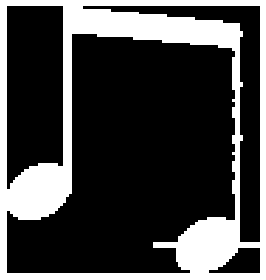

a_32


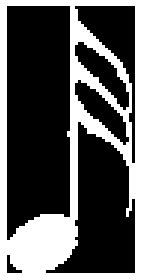

a_16


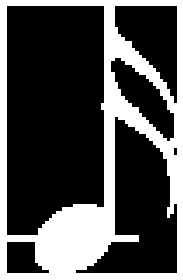

a_32


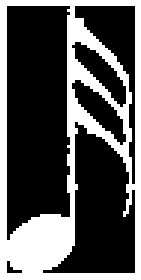

barline


barline


barline


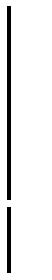

clef


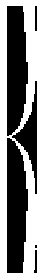

barline


clef


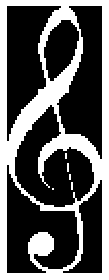

t_4


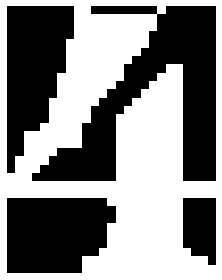

t_4


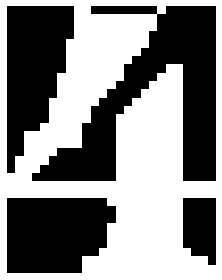

chord_3


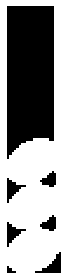

a_8


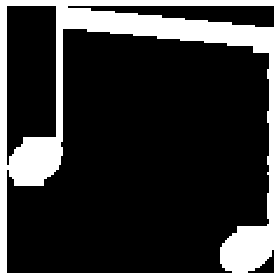

a_16


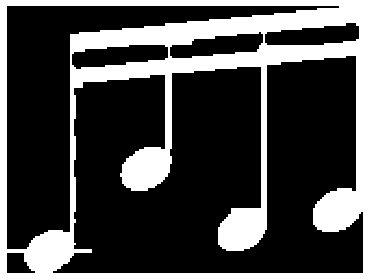

a_16_flipped


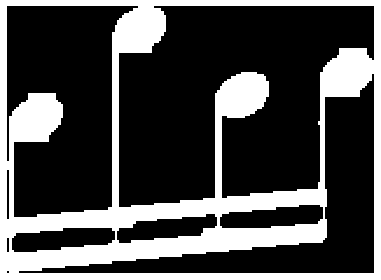

barline


chord_special


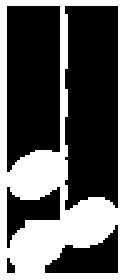

a_4


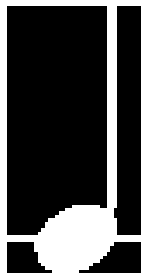

a_4


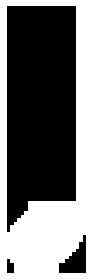

dot


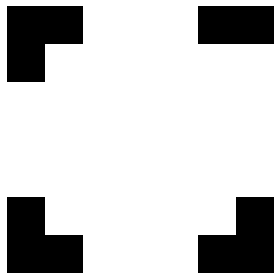

a_8


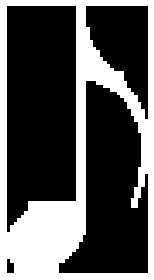

barline


a_32


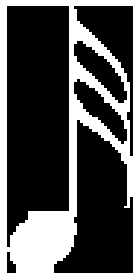

dot


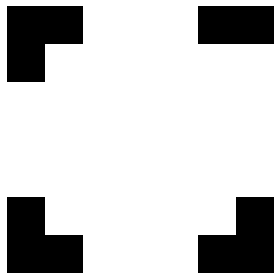

dot


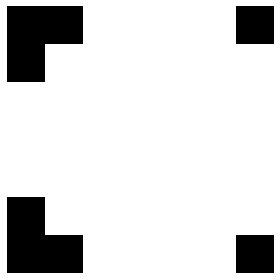

barline


barline


C:\Users\abdal\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


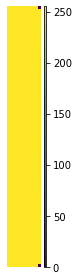

a_16_flipped


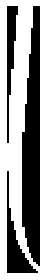

C:\Users\abdal\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


barline


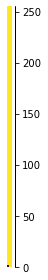

clef


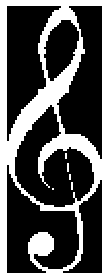

t_4


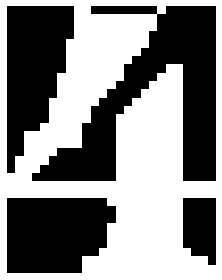

t_4


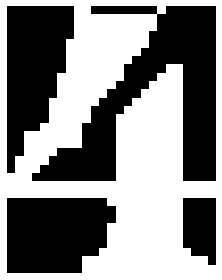

a_16


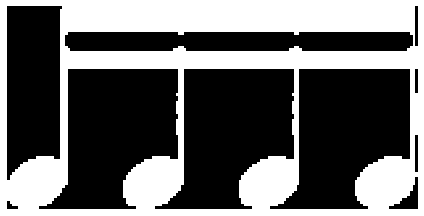

a_4


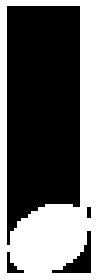

hash


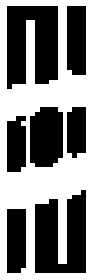

a_4


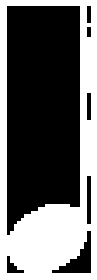

a_4


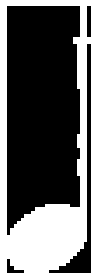

barline


symbol_bb


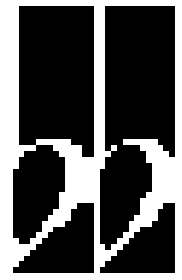

a_4


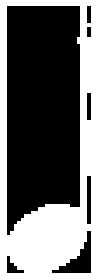

d


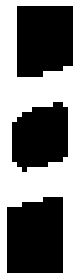

a_4


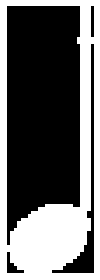

hash


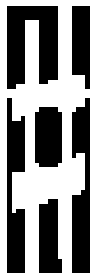

a_4_flipped


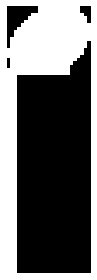

barline


barline


barline


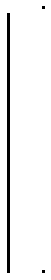

In [21]:
# Threshold for line to be considered as an initial staff line #
threshold = 0.8
correct_labels = np.load('correct_labels.npy')
accidentals = ['x', 'hash', 'b', 'symbol_bb', 'd']

for i in ['02']:
    try: 
        os.mkdir('testing-output/{}'.format(i)) 
    except OSError as error: 
        pass

    f = open(f"testing-output/{i}.txt", "w")
    

    # Get image and its dimensions#
    height, width, in_img = preprocess_img('{}/{}.png'.format(scanned_path, i), '{}'.format(i))
    
    # Get line thinkness and list of staff lines #
    staff_lines_thicknesses, staff_lines = get_staff_lines(width, height, in_img, threshold)

    # Remove staff lines from original image #
    cleaned = remove_staff_lines(in_img, width, staff_lines, staff_lines_thicknesses)
    cv2.imwrite('testing-output/{}/3. cleaned.png'.format(i), cleaned)
    
    # Get list of cutted buckets and cutting positions #
    cut_positions, cutted = cut_image_into_buckets(cleaned, staff_lines)
    
    # Get reference line for each bucket #
    ref_lines, lines_spacing = get_ref_lines(cut_positions, staff_lines)
    
    last_acc = ''
    last_num = ''
    if len(cutted) > 1:
        f.write('{\n')
    height_before = 0
    for it in range(len(cutted)):
        f.write('[')
        is_started = False
        cur_img = cutted[it].copy()
        
                
        symbols_boundries = segmentation(height_before, cutted[it])
        symbols_boundries.sort(key = lambda x: (x[0], x[1]))
        
        symbols = []
        for boundry in symbols_boundries:
            # Get the current symbol #
            x1, y1, x2, y2 = boundry
            cur_symbol = cutted[it][y1-height_before:y2+1-height_before, x1:x2+1]
            
            # Clean and cut #
            cur_symbol = clean_and_cut(cur_symbol)
            cur_symbol = 255 - cur_symbol

            # Start prediction of the current symbol #
            feature = extract_features(cur_symbol, 'hog')
            label = str(model.predict([feature])[0])
            org_label = label
            
            if label == 'clef':
                is_started = True

            if label == 'b_8':
                cutted_boundaries = cut_boundaries(cur_symbol, 2, y2)
                label = 'a_8'
            elif label == 'b_8_flipped':
                cutted_boundaries = cut_boundaries(cur_symbol, 2, y2)
                label = 'a_8_flipped'
            elif label == 'b_16':
                cutted_boundaries = cut_boundaries(cur_symbol, 4, y2)
                label = 'a_16'
            elif label == 'b_16_flipped':
                cutted_boundaries = cut_boundaries(cur_symbol, 4, y2)
                label = 'a_16_flipped'
            else: 
                cutted_boundaries = cut_boundaries(cur_symbol, 1, y2)
            
            for cutted_boundary in cutted_boundaries:
                ## TODO: text operations -> parameters(label, distance_to_the_ref_line => ref_line[it] - y2)
                _, y1, _, y2 = cutted_boundary
                if is_started == True and label != 'barline' and label != 'clef':
                    text = text_operation(label, ref_lines[it], lines_spacing[it], y1, y2)
                    
                    if (label == 't_2' or label == 't_4') and last_num == '':
                        last_num = text
                    elif label in accidentals:
                        last_acc = text
                    else:
                        if last_acc != '':
                            text = text[0] + last_acc + text[1:]
                            last_acc=  ''
                            
                        if last_num != '':
                            text = f'\meter<"{text}/{last_num}">'
                            last_num =  ''
                        
                        not_dot = label != 'dot'
                        f.write(not_dot * ' ' + text)
                    
                    
#             if correct_labels[cnt] != org_label:    
            print(label)
            plt.axis('off')
            io.imshow(cur_symbol)
            io.show()
            
        height_before += cutted[it].shape[0]
        f.write(' ]\n')
        
        cv2.imwrite(f'testing-output/{i}/4. cutted-{it + 1}.png', cutted[it])
        cv2.imwrite(f'testing-output/{i}/5. cutted-segmented-{it + 1}.png', cur_img)
    if len(cutted) > 1:
        f.write('}')
    f.close()        
